In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_squared_log_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
Cargo los datasets limpios
"""
df = pd.read_csv('house_train.csv')
df_test = pd.read_csv('house_test.csv')

In [3]:
# Asigno a "x" todas las columnas menos la de SalePrice y el Id y a "y" solamente el precio
x = df.drop(columns='SalePrice')
#x = df[['LotArea','LotFrontage','MSSubClass','GrLivArea','BsmtUnfSF','TotalBsmtSF','BsmtFinSF1','GarageArea','1stFlrSF']]
y = df['SalePrice']

# En este caso que solo tengo los precios de un dataset, lo divido para poder evaluarlo
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [5]:
"""
Regresión lineal múltiple con sklearn
"""

# Creo el modelo lineal
lrm = linear_model.LinearRegression()

# Entreno al modelo
lrm.fit(x_train,y_train)

# hago el predict del conjunto de test para el score (AHORA NO LO ESTOY USANDO)
#y_pred = lrm.predict(x_test)

# hago el predict de todos los datos para el RMSLE
y_pred = lrm.predict(x)

In [6]:
"""
Resultado con sklearn
"""

mean_squared_log_error(y, y_pred, squared=False)

0.15720029538605826

0.15720029538605826

In [7]:
"""
regressor de xgboost
"""

xgbr = xgboost.XGBRegressor(n_estimators=600,
                            learning_rate=0.04,
                            max_depth=5,
                            gpu_id=0,               # Usa la GPU RTX 2080ti
                            min_child_weight=1,
                            subsample=0.8,
                            gamma=0.1,
                            reg_alpha=None,
                            reg_lambda=None
)

xgbr.fit(x_train,y_train)

y_pred_train = xgbr.predict(x_train)
y_pred_test = xgbr.predict(x_test)
y_pred = xgbr.predict(x)

In [18]:
"""
Resultado con xgboost
"""
print('test:  '+str(mean_squared_log_error(y_test, y_pred_test, squared=False)))
print('train: '+str(mean_squared_log_error(y_train, y_pred_train, squared=False)))

test:  0.009429228189810913
train: 0.017089902555530043


test:  0.09710421303842029
train: 0.017089902555530043

In [16]:
"""
Creando la prediccion del archivo test y guardandolo en un csv
"""

pred_final = xgbr.predict(df_test)
pred_final = pd.DataFrame(pred_final)
pred_final = pred_final.rename(columns={0:'pred'})
pred_final.to_csv('pred_test.csv', index=False)

In [ ]:
"""
Esta parte la usé para ajustar los hiperparámetros del xgboost
"""

tuned_parameters = {
    'max_depth':[4,5,6],
    'min_child_weight':[1,2,3],
    'gamma':[0.1, 0.2],
    'learning_rate':[0.05,0.1],
    'n_estimators':[600,700]
}

clf = GridSearchCV(xgbr, param_grid=tuned_parameters,cv=5)

#clf.fit(x_train,y_train)

print('Mejores parametros: '+str(clf.best_params_))
print('Mejor score: '+str(clf.best_score_))
"""
{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 500} 0.9344996762803033
{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 500} 0.9375065010752852
{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 600} 0.9541262629680018
{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 600} 0.9541262629680018
"""

las columnas con mas ponderacion

'LotArea','LotFrontage','MSSubClass','GrLivArea','BsmtUnfSF','TotalBsmtSF','BsmtFinSF1','GarageArea','1stFlrSF'

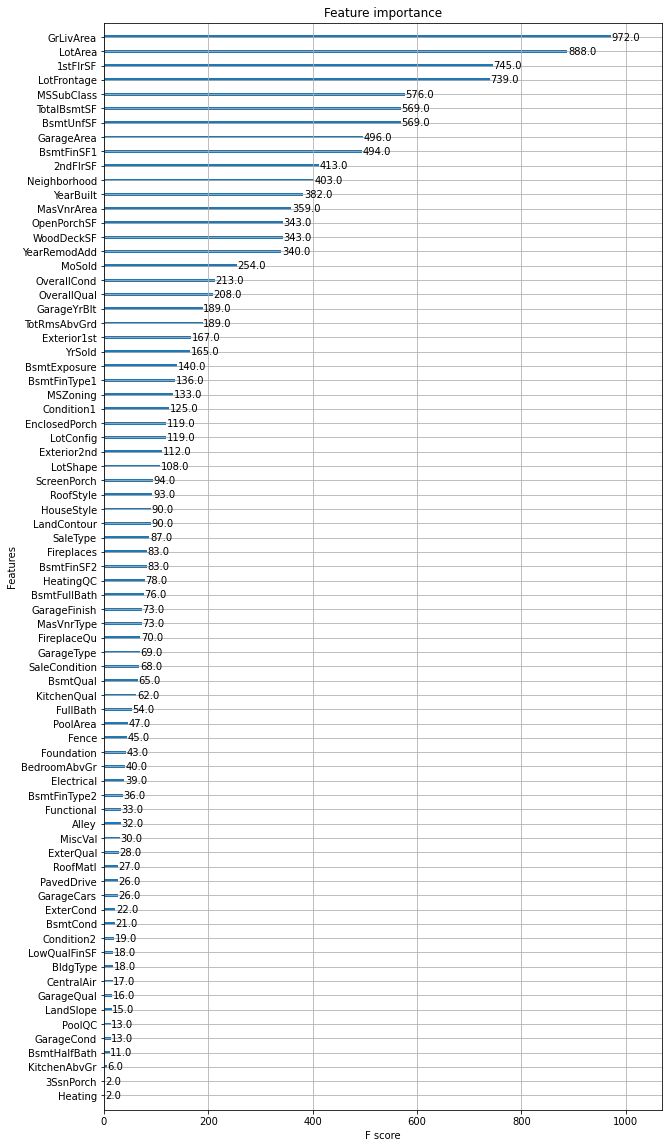

In [10]:
plt.figure(figsize=(10, 20))
xgboost.plot_importance(xgbr, ax=plt.gca())

plt.show()